# Library analysis, comparison, and cost efficiency calculation


Library reagents and experiments, whether from combinatorial or bespoke libraries, are resource intensive. The OpenProtein.AI platform provides tools to make informed decisions around cost-performance trade-offs.  

This walkthrough shows you how to use the OpenProtein.AI Python client to analyze and compare libraries for expected performance. In this example, we evaluate ML-designed and combinatorial variant libraries and demonstrate how a user can make data-driven decisions around library composition and size to achieve success with a given confidence level.


## What you need before getting started

You need an OpenProtein.AI account and a dataset with sequence and property
measurements. This tutorial uses the [antibody variable fragment mutagenesis
dataset,
14H](https://drive.google.com/uc?export=download&id=1L4AeuW50EKFKczxLf_YCUM4lC370eNqe).

## Setting up your environment

You also need a Jupyter notebook environment for data analysis and visualization:


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import spearmanr
import json

Next, connect to the OpenProtein.AI backend using your credentials:

In [ ]:
import openprotein

with open('secrets.config', 'r') as f:
    config = json.load(f)

session = openprotein.connect(config['username'], config['password'])

In [3]:
openprotein.__version__

'0.5.5'

## Load data for analysis

 We'll use an antibody variable fragment mutagenesis dataset, 14H. This dataset contains heavy chain variable fragment sequences mutagensized in all three CDRs with measured binding affinities.

 Upload the dataset:

In [4]:
path = '14H_affinities_nonan.csv'
table = pd.read_csv(path)
print(table.shape)
table.head()

(7476, 2)


,sequence,log_kdnm
0,EVQLVETGGGLVQPGGSLRLSCAASPFELNSYGISWVRQAPGKGPE...,2.696930
1,EVQLVETGGGLVQPGGSLRLSCAASGFDLNSYGISWVRQAPGKGPE...,1.988077
2,EVQLVETGGGLVQPGGSLRLSCAASGFKLNSYGISWVRQAPGKGPE...,2.975487
3,EVQLVETGGGLVQPGGSLRLSCAASGFHLNSYGISWVRQAPGKGPE...,2.381006
4,EVQLVETGGGLVQPGGSLRLSCAASGFTLLSYGISWVRQAPGKGPE...,3.481793


As we can see above, the dataset is displayed with each row representing a sequence along with its corresponding 'log_kdnm' value.

Post the dataset to train a model for affinity prediction:

In [5]:
dataset = session.data.create(table, '14H_affinities', 'Antibody heavy chain variable region mutagenesis with affinity measurements.')
dataset

AssayMetadata(assay_name='14H_affinities', assay_description='Antibody heavy chain variable region mutagenesis with affinity measurements.', assay_id='8b266b5f-9e86-4efe-9f1c-8350eaabaa85', original_filename='assay_data', created_date=datetime.datetime(2024, 12, 9, 10, 18, 2, 127243), num_rows=7476, num_entries=7476, measurement_names=['log_kdnm'], sequence_length=118)

The returned AssayMetadata object contains information about the assay metadata, including the model configuration, assay name, description, ID, original filename, creation date, number of rows, number of entries, measurement names, and sequence length.

### Train a sequence-to-function prediction model

We’re ready to train the model using our dataset:

In [6]:
model_future = session.train.create_training_job(dataset, 'log_kdnm')
print(model_future.job)
model_future.wait_until_done(verbose=True)

job_id='a4afcb37-1a63-4ca7-b0cf-80350d3edc23' job_type=<JobType.workflow_train: '/workflow/train'> status=<JobStatus.PENDING: 'PENDING'> created_date=datetime.datetime(2024, 12, 9, 10, 18, 38, 62795) start_date=None end_date=None prerequisite_job_id='ae9d2133-db5a-43a3-8bdb-b9c947a6c4c3' progress_message=None progress_counter=None sequence_length=118 traingraph=None


Waiting: 100%|██████████| 100/100 [04:31<00:00,  2.72s/it, status=SUCCESS]


True

#### Run cross validation

It's important to evaluate the trained model’s performance through cross-validation. This process estimates the model's predictive abilities by simulating how well it would perform on independent datasets.


In [7]:
model_future.crossvalidate()
cv_future = model_future.crossvalidation
print(cv_future)
cv_future.wait_until_done(verbose=True)

job_id='8c4276e9-559b-40e3-b4cb-ec92efabcc7f' job_type=<JobType.workflow_crossvalidate: '/workflow/crossvalidate'> status=<JobStatus.PENDING: 'PENDING'> created_date=datetime.datetime(2024, 12, 9, 10, 23, 23, 524165) start_date=None end_date=None prerequisite_job_id='a4afcb37-1a63-4ca7-b0cf-80350d3edc23' progress_message=None progress_counter=None sequence_length=None num_rows=None page_size=None page_offset=None result=None


Waiting: 100%|██████████| 100/100 [00:26<00:00,  3.72it/s, status=SUCCESS]


True

Retrieve the results of the cross-validation process with:

In [8]:
cv_results = cv_future.get()

The next step is to process the cross-validation results and visualize the relationship between predicted and actual affinities on a scatter plot.

In [9]:
y = []
y_mu = []
y_var = []
for r in cv_results:
    y.append(r.y)
    y_mu.append(r.y_mu)
    y_var.append(r.y_var)
y = np.array(y)
y_mu = np.array(y_mu)
y_var = np.array(y_var)

y.shape, y_mu.shape, y_var.shape

((7476,), (7476,), (7476,))

SignificanceResult(statistic=0.6943116570414379, pvalue=0.0)


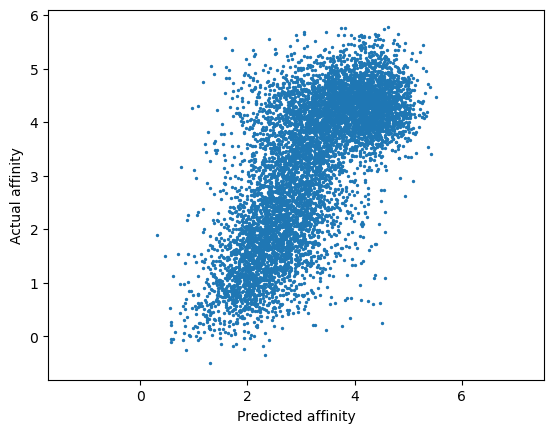

In [12]:
print(spearmanr(y_mu, y))
plt.scatter(y_mu, y, s=2)
plt.axis('equal')
plt.xlabel('Predicted affinity')
plt.ylabel('Actual affinity')
plt.show()

Cross validation performance is strong, as indicated by a Spearman rho = 0.694. We’re ready to start working with our model.

### Use the design API to identify variants with enhanced binding affinity

Design criteria are specified as a list of lists of criteria. This allows describing 'and' and 'or' relationships between them. Each inner list of critera represents a single 'and' criterion. That is, the criterion is that all criteria in the inner list are true. The outer list represents 'or' criteria and the solver searches for solutions across the Pareto front of these criteria.

An addition special criterion called `NMutationCriterion` can also be specified. This criterion specifies the number of mutations away from the training data and can be included to explore solutions trading off the success probability criteria with the number of introduced mutations.

Note that the same model and measurement can be used in multiple criteria to, for example, explore the Pareto front between criteria of varying stringency in order to explore more and less risky designs.

In this example we just use a single criteria for the binding affinity target with no number of mutations criteria.

In [20]:
# create the design objective
# look for variants that will have single digit picomolar affinity, Kd <10 pm (< -2 log Kd)
from openprotein.schemas import ModelCriterion, NMutationCriterion

target = -2.0
criterion = [
    [ModelCriterion(
        criterion_type = 'model',
        model_id = model_future.job.job_id,
        measurement_name = 'log_kdnm',
        criterion = dict(target=target, weight=1.0, direction='<'),
    )],
    # [NMutationCriterion(criterion_type="n_mutations", )]
]

In [ ]:
# create the design constraints
# constraints are an optional dictionary mapping sites to amino acids allowed at those sites

# in this case, we want to only allow mutations in the CDRs
# Note that sites are 1-indexed following the usual biological sequence indexing convention

parent = table['sequence'].iloc[0] # not the actual parent, but not important for our purposes since the sequence outside of the CDRs is constant across the dataset
print(parent)

# only allow parent sequence amino acid outside of CDRs and allow any amino acid within the CDRs
constraints = {i+1: [aa] for i,aa in enumerate(parent)} # parent sequence constraint

# constraints[3] = ['G', 'L'] # <- to allow only G and L at site 3, for example
all_amino_acids = [c for c in 'GPAVLIMCFYWHKRQNEDST']
sites = [ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         98,  99, 100, 101, 102, 103, 104, 105, 106]
for site in sites:
    constraints[site] = all_amino_acids

print(constraints)

EVQLVETGGGLVQPGGSLRLSCAASPFELNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSS
{1: ['E'], 2: ['V'], 3: ['Q'], 4: ['L'], 5: ['V'], 6: ['E'], 7: ['T'], 8: ['G'], 9: ['G'], 10: ['G'], 11: ['L'], 12: ['V'], 13: ['Q'], 14: ['P'], 15: ['G'], 16: ['G'], 17: ['S'], 18: ['L'], 19: ['R'], 20: ['L'], 21: ['S'], 22: ['C'], 23: ['A'], 24: ['A'], 25: ['G', 'P', 'A', 'V', 'L', 'I', 'M', 'C', 'F', 'Y', 'W', 'H', 'K', 'R', 'Q', 'N', 'E', 'D', 'S', 'T'], 26: ['G', 'P', 'A', 'V', 'L', 'I', 'M', 'C', 'F', 'Y', 'W', 'H', 'K', 'R', 'Q', 'N', 'E', 'D', 'S', 'T'], 27: ['G', 'P', 'A', 'V', 'L', 'I', 'M', 'C', 'F', 'Y', 'W', 'H', 'K', 'R', 'Q', 'N', 'E', 'D', 'S', 'T'], 28: ['G', 'P', 'A', 'V', 'L', 'I', 'M', 'C', 'F', 'Y', 'W', 'H', 'K', 'R', 'Q', 'N', 'E', 'D', 'S', 'T'], 29: ['G', 'P', 'A', 'V', 'L', 'I', 'M', 'C', 'F', 'Y', 'W', 'H', 'K', 'R', 'Q', 'N', 'E', 'D', 'S', 'T'], 30: ['G', 'P', 'A', 'V', 'L', 'I', 'M', 'C', 'F', 'Y', 'W', 'H', 'K', 'R', 'Q', 'N', 'E', 'D', 

In [28]:
# set the solver parameters and start the design run
from openprotein.schemas.design import DesignJobCreate

# run the algorithm for 50 steps with otherwise default parameters
design_params = DesignJobCreate(
    assay_id = dataset.id,
    criteria = criterion,
    num_steps = 50,
    allowed_tokens = constraints,
)

design_future = session.design.create_design_job(design_params)
print(design_future.job)
design_future.wait_until_done(verbose=True)

job_id='85c0cfab-acc9-4854-bc1d-6785d40755da' job_type=<JobType.workflow_design: '/workflow/design'> status=<JobStatus.PENDING: 'PENDING'> created_date=datetime.datetime(2024, 12, 9, 10, 47, 50, 606745) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=None sequence_length=None


Waiting: 100%|██████████| 100/100 [29:08<00:00, 17.49s/it, status=SUCCESS]


True

#### Retrieve the design results

Results are a list of objects containing the generated sequences, algorithm step, and scores and prediction values for each sequence.

Key attributes are:
- `r.sequence`
- `r.step`
- `r.scores`

Scores are a list of lists of objects containing results for each criteria. These objects have
- `score.score`: the log-probability that the sequence achieves this criterion
- `score.metadata`: contains `y_mu` and `y_var` the mean and variance given by the prediction model for the property in this criterion

In [36]:
# get the design results and parse them into a table for analysis
design_results = design_future.get()

rows = []
for r in design_results:
    scores = r.scores[0][0]
    y_mu = scores.metadata.y_mu
    y_var = scores.metadata.y_var
    score = scores.score
    row = [r.step, score, y_mu, y_var, r.sequence]
    rows.append(row)
design_results = pd.DataFrame(rows, columns=['step', 'score', 'y_mu', 'y_var', 'sequence'])
print(design_results.shape)
design_results.sort_values('score', ascending=False).head()

(12800, 5)


,step,score,y_mu,y_var,sequence
6400,25,-1.675267,-1.452686,0.379842,EVQLVETGGGLVQPGGSLRLSCAASGFSLNEYGISWVRQAPGKGPE...
11520,45,-1.675267,-1.452686,0.379842,EVQLVETGGGLVQPGGSLRLSCAASGFSLNEYGISWVRQAPGKGPE...
3584,14,-1.675267,-1.452686,0.379842,EVQLVETGGGLVQPGGSLRLSCAASGFSLNEYGISWVRQAPGKGPE...
9984,39,-1.675267,-1.452686,0.379842,EVQLVETGGGLVQPGGSLRLSCAASGFSLNEYGISWVRQAPGKGPE...
4864,19,-1.675267,-1.452686,0.379842,EVQLVETGGGLVQPGGSLRLSCAASGFSLNEYGISWVRQAPGKGPE...


## Analyze possible libraries from the design results

Filter and sort the design results in different ways to compare different sequence subsets and the expected performance of those libraries.

In [37]:
design_results_filtered = design_results.drop_duplicates('sequence').sort_values(['score', 'y_mu'], ascending=[False, True])
print(design_results_filtered.shape)
design_results_filtered.head()

(2310, 5)


,step,score,y_mu,y_var,sequence
1792,7,-1.675267,-1.452686,0.379842,EVQLVETGGGLVQPGGSLRLSCAASGFSLNEYGISWVRQAPGKGPE...
2049,8,-1.709151,-1.403919,0.427670,EVQLVETGGGLVQPGGSLRLSCAASGFSLNEYGISWVRQAPGKGPE...
2306,9,-1.745189,-1.412508,0.393879,EVQLVETGGGLVQPGGSLRLSCAASGFSLNEYGISWVRQAPGKGPE...
2050,8,-1.751527,-1.399642,0.407573,EVQLVETGGGLVQPGGSLRLSCAASGFSLNEYGISWVRQAPGKGPE...
2308,9,-1.754668,-1.403978,0.399898,EVQLVETGGGLVQPGGSLRLSCAASGFSLNEYGISWVRQAPGKGPE...


In [38]:
library_1000 = design_results_filtered.iloc[:1000]
library_100 = design_results_filtered.iloc[:100]

pred_dist_1000 = scipy.stats.norm(library_1000.y_mu, np.sqrt(library_1000.y_var))
pred_dist_100 = scipy.stats.norm(library_100.y_mu, np.sqrt(library_100.y_var))

### Examine the expected distributions over affinites in the designed libraries versus the initial dataset

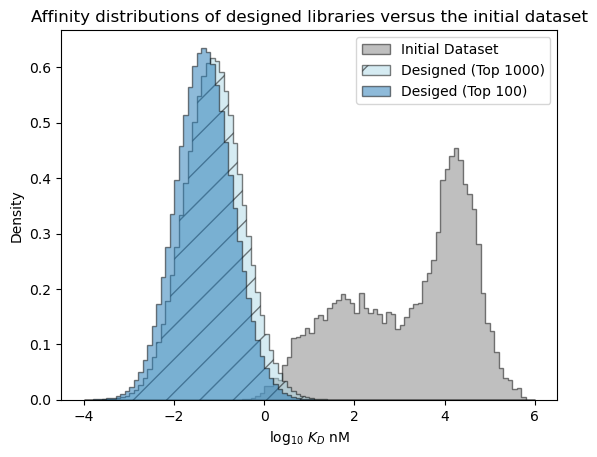

In [41]:
# plot the expected results vs. the input data
bins = np.linspace(-4, 6, 101)

format_params = {'alpha': 0.5, 'histtype': 'stepfilled', 'ec': 'k'}
_ = plt.hist(table['log_kdnm'].values, bins=bins, label='Initial Dataset', color='gray', density=True, **format_params)

# plot the predictive distribution over property values
c_lo = pred_dist_1000.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = pred_dist_1000.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='Designed (Top 1000)', color='lightblue', hatch='/', **format_params)

c_lo = pred_dist_100.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = pred_dist_100.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='Desiged (Top 100)', **format_params)

_ = plt.legend(loc='best')
_ = plt.xlabel('log$_{10}$ $K_D$ nM')
_ = plt.ylabel('Density')
_ = plt.title('Affinity distributions of designed libraries versus the initial dataset')

plt.show()

### Examine the predictive distribution over the _best_ affinity in each library

Above, we looked at the overall expected distribution of affinities, but we may actually be interested in what the affinity value of the _best_ sequence in a library is likely to be. When comparing the libraries of size 100 and size 1,000, the affinity distributions are expected to be nearly identical, but we would expect a larger library to be *more likely* to contain a sequence that meets the design criteria (log KD < -2) and to contain a _best_ sequence with stronger affinity.

#### Probability of containing a success

In [42]:
# what is the probability that a variant meeting the design criteria is present in each library?
target = -2
print('target value <', target)

log_one_minus_p_1000 = pred_dist_1000.logsf(target)
p_1000 = 1 - np.exp(np.sum(log_one_minus_p_1000)) # the probability that at least one sequence meets the target value
print(f'Designed (Top 1000), probability of at least one success = {p_1000:.5f}')

log_one_minus_p_100 = pred_dist_100.logsf(target)
p_100 = 1 - np.exp(np.sum(log_one_minus_p_100))
print(f'Designed (Top 100), probability of at least one success = {p_100:.5f}')

target value < -2
Designed (Top 1000), probability of at least one success = 1.00000
Designed (Top 100), probability of at least one success = 1.00000


In [43]:
# in this case, we think that both libraries are virtually guaranteed to contain a successful variant!
# let's take a more fine-grained look

log_one_minus_p = pred_dist_1000.logsf(target)
print('Top k', 'Probability', sep='\t')
for i in range(20):
    p = 1 - np.exp(np.sum(log_one_minus_p[:i+1]))
    print(f'{i+1:2>d}', f'{p:.5f}', sep='\t')

Top k	Probability
1	0.18726
2	0.33438
3	0.45061
4	0.54593
5	0.62447
6	0.68922
7	0.74263
8	0.78681
9	0.82316
10	0.85326
11	0.87821
12	0.89877
13	0.91566
14	0.92959
15	0.94113
16	0.95075
17	0.95875
18	0.96544
19	0.97097
20	0.97555


As we can see, we would only need to test a few sequences to have high probability of finding one that has picomolar affinity. We can also use this kind of analysis to determine how large our library should be given a success confidence level. For example, if we wanted a library with at least 0.95 probability of containing a variant with picomolar affinity (only 1/20 chance of failure), then we would only need to test the top 16 sequences to achieve this.

In [45]:
# let's perform the same analysis but for a more aggresive affinity target value
target = -3
print('target value <', target)

log_one_minus_p_1000 = pred_dist_1000.logsf(target)
p_1000 = 1 - np.exp(np.sum(log_one_minus_p_1000)) # the probability that at least one sequence meets the target value
print(f'Designed (Top 1000), probability of at least one success = {p_1000:.5f}')

log_one_minus_p_100 = pred_dist_100.logsf(target)
p_100 = 1 - np.exp(np.sum(log_one_minus_p_100))
print(f'Designed (Top 100), probability of at least one success = {p_100:.5f}')

target value < -3
Designed (Top 1000), probability of at least one success = 0.85437
Designed (Top 100), probability of at least one success = 0.33712


In [46]:
# now we can see clearer resolution between library sizes and would need a much larger library to be confident
# that it will include a sequence with log kd < -3

log_one_minus_p = pred_dist_1000.logsf(target)
print('Top k', 'Probability', sep='\t')
for i in range(20):
    p = 1 - np.exp(np.sum(log_one_minus_p[:i+1]))
    print(f'{i+1:2>d}', f'{p:.5f}', sep='\t')

Top k	Probability
1	0.00603
2	0.01331
3	0.01895
4	0.02493
5	0.03058
6	0.03333
7	0.03856
8	0.04437
9	0.04987
10	0.05460
11	0.05913
12	0.06454
13	0.06793
14	0.07092
15	0.07405
16	0.07735
17	0.08330
18	0.08693
19	0.09204
20	0.09756


#### Predicted distribution over the best affinity in each library

Next, let's examine the distribution over the affinity of the *best* sequence we expect to see in each library.

In [47]:
# estimate best affinities in each library from sampling
num_samples = 10_000

r = np.random.randn(num_samples, 1000)*pred_dist_1000.std() + pred_dist_1000.mean()
sample_best_1000 = r.min(axis=-1)

r = np.random.randn(num_samples, 100)*pred_dist_100.std() + pred_dist_100.mean()
sample_best_100 = r.min(axis=-1)

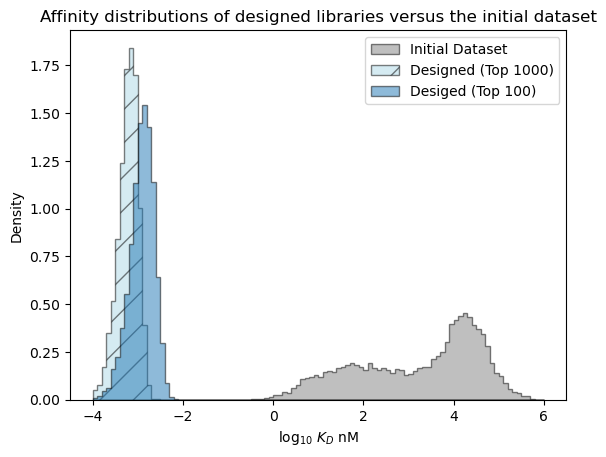

In [48]:
# plot the expected results vs. the input data
bins = np.linspace(-4, 6, 101)

format_params = {'alpha': 0.5, 'histtype': 'stepfilled', 'ec': 'k'}
_ = plt.hist(table['log_kdnm'].values, bins=bins, label='Initial Dataset', color='gray', density=True, **format_params)

# plot the predictive distribution over property values
_ = plt.hist(sample_best_1000, bins=bins, label='Designed (Top 1000)', color='lightblue', density=True, hatch='/', **format_params)

_ = plt.hist(sample_best_100, bins=bins, label='Desiged (Top 100)', density=True, **format_params)

_ = plt.legend(loc='best')
_ = plt.xlabel('log$_{10}$ $K_D$ nM')
_ = plt.ylabel('Density')
_ = plt.title('Affinity distributions of designed libraries versus the initial dataset')

plt.show()

In [49]:
# plot out the expected best value versus library size
r = np.random.randn(num_samples, 1000)*pred_dist_1000.std() + pred_dist_1000.mean()
print('Top k', 'E[Best Affinity]', sep='\t')
for i in range(20):
    sample_best = r[:, :i+1].min(axis=-1)
    expected_best_value = sample_best.mean()
    print(f'{i+1:2>d}', f'{expected_best_value:.5f}', sep='\t')

Top k	E[Best Affinity]
1	-1.44319
2	-1.78705
3	-1.96071
4	-2.06998
5	-2.15123
6	-2.21103
7	-2.26196
8	-2.30447
9	-2.34145
10	-2.37264
11	-2.40101
12	-2.42664
13	-2.44703
14	-2.46452
15	-2.48150
16	-2.49785
17	-2.51706
18	-2.53072
19	-2.54542
20	-2.56078


### ML-designed sequences are divergent from the initial dataset

The variants we've identified are divergent from anything present in the initial dataset. Let's calculate some edit distance statistics between our top 1000 sequence library and the sequences in the initial dataset.

In [50]:
x_1000 = library_1000['sequence'].values
x_1000 = np.array([[c for c in x_1000[i]] for i in range(len(x_1000))])
print(x_1000.shape)

x_init = table['sequence'].values
x_init = np.array([[c for c in x_init[i]] for i in range(len(x_init))])
print(x_init.shape)

edit_dist = 0
for i in range(x_1000.shape[1]):
    edit_dist += (x_1000[:, i][:, np.newaxis] != x_init[:, i])
edit_dist.shape

(1000, 118)
(7476, 118)


(1000, 7476)

4 6.723 9


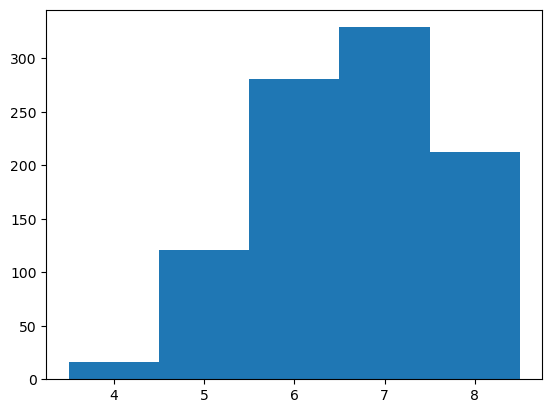

In [51]:
min_edit_dist = edit_dist.min(axis=-1)
print(min_edit_dist.min(), min_edit_dist.mean(), min_edit_dist.max())

bins = np.arange(min_edit_dist.min(), min_edit_dist.max()+1) - 0.5
_ = plt.hist(min_edit_dist, bins=bins)

plt.show()

Sequences in the top 1000 library are, on average, more than 6 edits away from the _most similar_ sequence in the inital library and the most divergent variant identified is *9* mutations away from anything in the initial library.

## Compare top sequences against alternative library designs

### Design a conventional combinatorial variant library (CVL)

A typical library design approach is to re-randomize the substitution variants found in the intial screen. Let's build a CVL based on the variants found in the top 50 sequences.

In [52]:
# randomize the variants found in the best sequences in the initial library
# to create a CVL

amino_acids = 'ARNDCQEGHILKMFPSTWYV'
amino_acid_to_index = {amino_acids[i]: i for i in range(len(amino_acids))}

topk = 50
sequences = table.sort_values('log_kdnm').head(n=topk)['sequence'].values
sequences = np.array([[amino_acid_to_index[sequences[i][j]] for j in range(len(sequences[i]))] for i in range(len(sequences))])
sequences.shape


(50, 118)

In [53]:
counts = np.zeros((sequences.shape[1], len(amino_acids)))
for i in range(sequences.shape[1]):
    index, count = np.unique(sequences[:, i], return_counts=True)
    counts[i, index] = count
counts = (counts > 1)
cvl = counts/counts.sum(axis=-1, keepdims=True)

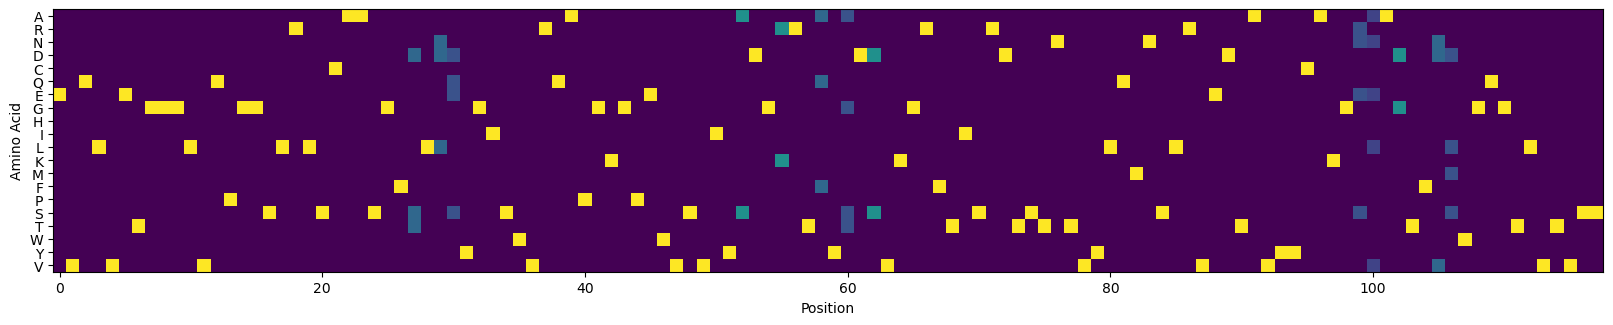

In [56]:
# visualize the CVL
_, ax = plt.subplots(figsize=(20, 4))
ax.imshow(cvl.T)
_ = ax.set_yticks(np.arange(len(amino_acids)), [c for c in amino_acids])
_ = ax.set_xlabel('Position')
_ = ax.set_ylabel('Amino Acid')

plt.show()

#### Assess the expected performance of the conventional CVL

In [57]:
library_size = 10_000
random = np.random.RandomState(42)
cvl_sequences_sampled = np.zeros((library_size, cvl.shape[0]), dtype=int)
for i in range(len(cvl)):
    cvl_sequences_sampled[:, i] = random.choice(len(cvl[i]), p=cvl[i], size=(library_size), replace=True)
cvl_sequences_sampled = [''.join([amino_acids[i] for i in cvl_sequences_sampled[j]]) for j in range(cvl_sequences_sampled.shape[0])]
# only consider the unique sequences
cvl_sequences_sampled = np.unique(cvl_sequences_sampled).tolist()

In [58]:
cvl_predict_future = model_future.predict(cvl_sequences_sampled)
print(cvl_predict_future.job)
cvl_predict_future.wait_until_done(verbose=True)

job_id='d4e689ac-10d0-4e03-94a2-56b7621ae145' job_type=<JobType.workflow_predict: '/workflow/predict'> status=<JobStatus.PENDING: 'PENDING'> created_date=None start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=None sequence_length=None result=None


Waiting: 100%|██████████| 100/100 [04:00<00:00,  2.41s/it, status=SUCCESS]


True

In [59]:
cvl_predict_results = cvl_predict_future.get()

cvl_y_mus = np.zeros(len(cvl_predict_results))
cvl_y_vars = np.zeros(len(cvl_predict_results))
for i,r in enumerate(cvl_predict_results):
    props = r.predictions[0].properties['log_kdnm']
    cvl_y_mus[i] = props['y_mu']
    cvl_y_vars[i] = props['y_var']
cvl_dists = scipy.stats.norm(cvl_y_mus, np.sqrt(cvl_y_vars))

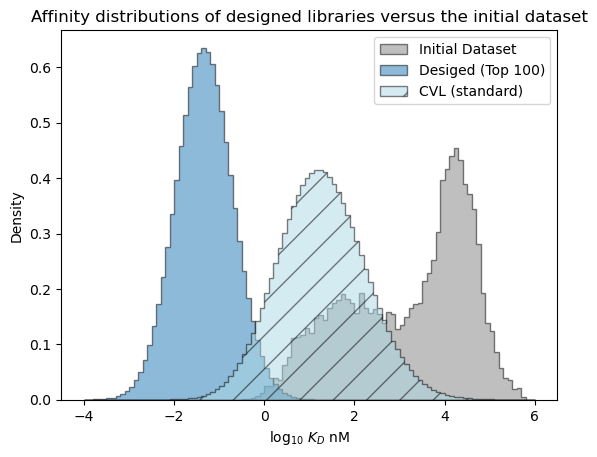

In [60]:
# plot the expected results vs. the input data
bins = np.linspace(-4, 6, 101)

format_params = {'alpha': 0.5, 'histtype': 'stepfilled', 'ec': 'k'}
_ = plt.hist(table['log_kdnm'].values, bins=bins, label='Initial Dataset', color='gray', density=True, **format_params)

# plot the predictive distribution over property values
c_lo = pred_dist_100.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = pred_dist_100.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='Desiged (Top 100)', **format_params)

# compare the expected performance of the 10,000 sequences from the CVL
c_lo = cvl_dists.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = cvl_dists.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='CVL (standard)', color='lightblue', hatch='/', **format_params)

_ = plt.legend(loc='best')
_ = plt.xlabel('log$_{10}$ $K_D$ nM')
_ = plt.ylabel('Density')
_ = plt.title('Affinity distributions of designed libraries versus the initial dataset')

plt.show()

The expected performance of a sequence in the standard CVL is expected to be better than the average sequence in the initial dataset and may improve over the best sequences in the intial library, but is expected to be significantly worse than the sequences in the bespoke library we created with the design API.

#### Compare the library success statistics

In [61]:
# what is the probability that a variant meeting the design criteria is present in each library?
# if we tested 10,000 sequences from the CVL, how would it compare with the bespoke top 100 sequences?
target = -2
print('target value <', target)

log_one_minus_p_100 = pred_dist_100.logsf(target)
p_100 = 1 - np.exp(np.sum(log_one_minus_p_100))
print(f'Designed, 100 sequences, probability of at least one success = {p_100:.5f}')

log_one_minus_p_cvl = cvl_dists.logsf(target)
p_cvl = 1 - np.exp(np.sum(log_one_minus_p_cvl))
print(f'CVL (standard), 10,000 sequences, probability of at least one success = {p_cvl:.5f}')

target value < -2
Designed, 100 sequences, probability of at least one success = 1.00000
CVL (standard), 10,000 sequences, probability of at least one success = 0.74083


We can see that even if we test 10,000 sequences from the CVL, the probability of finding a sequence that meets our target affinity (picomolar) is only about 74%, significantly lower than the virtual certainty that a success will be contained in the bespoke 100 sequence library. If we compare this with the fine-grained results above, we can see that we would need to test less than 10 of the top bespoke sequence designs to have the same probability of success.

#### Predicted distribution over the best affinity in each library

Next, let's examine the distribution over the affinity of the *best* sequence we expect to see in each library.

In [62]:
cvl_dists.std().shape

(9969,)

In [63]:
# estimate best affinities in each library from sampling
num_samples = 10_000

r = np.random.randn(num_samples, len(cvl_y_mus))*cvl_dists.std() + cvl_dists.mean()
sample_cvl = r.min(axis=-1)

r = np.random.randn(num_samples, 100)*pred_dist_100.std() + pred_dist_100.mean()
sample_best_100 = r.min(axis=-1)

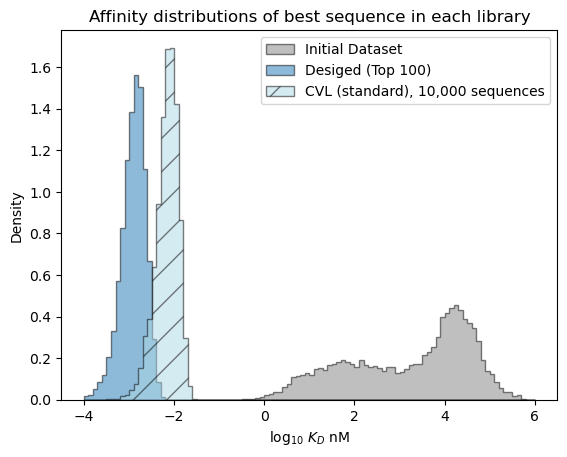

In [64]:
# plot the expected results vs. the input data
bins = np.linspace(-4, 6, 101)

format_params = {'alpha': 0.5, 'histtype': 'stepfilled', 'ec': 'k'}
_ = plt.hist(table['log_kdnm'].values, bins=bins, label='Initial Dataset', color='gray', density=True, **format_params)

# plot the predictive distribution over property values
_ = plt.hist(sample_best_100, bins=bins, label='Desiged (Top 100)', density=True, **format_params)
_ = plt.hist(sample_cvl, bins=bins, label='CVL (standard), 10,000 sequences', color='lightblue', density=True, hatch='/', **format_params)

_ = plt.legend(loc='best')
_ = plt.xlabel('log$_{10}$ $K_D$ nM')
_ = plt.ylabel('Density')
_ = plt.title('Affinity distributions of best sequence in each library')

plt.show()

In [ ]:
# plot out the expected best value versus library size
# lower KD is better
r_des = np.random.randn(num_samples, 1000)*pred_dist_1000.std() + pred_dist_1000.mean()
r_cvl = np.random.randn(num_samples, len(cvl_y_mus))*cvl_dists.std() + cvl_dists.mean()
print('Library Size', 'E[Best log KD | Bespoke]', 'E[Best log KD | CVL (standard)]', sep='\t')
for i in range(20):
    sample_best = r_des[:, :i+1].min(axis=-1)
    expected_best_value_des = sample_best.mean()
    sample_best = r_cvl[:, :i+1].min(axis=-1)
    expected_best_value_cvl = sample_best.mean()
    print(f'{i+1: 12d}', f'{expected_best_value_des:26.5f}', f'{expected_best_value_cvl:33.5f}', sep='\t')

Library Size	E[Best log KD | Bespoke]	E[Best log KD | CVL (standard)]
           1	                  -1.45210	                          1.50974
           2	                  -1.78581	                          1.06134
           3	                  -1.96041	                          0.63016
           4	                  -2.07076	                          0.28969
           5	                  -2.15067	                         -0.10031
           6	                  -2.21040	                         -0.12061
           7	                  -2.26153	                         -0.16312
           8	                  -2.30829	                         -0.18107
           9	                  -2.34465	                         -0.18203
          10	                  -2.37733	                         -0.18689
          11	                  -2.40579	                         -0.20375
          12	                  -2.43231	                         -0.25236
          13	                  -2.45274	  

### Design a better combinatorial variant library from the OpenProtein.AI design results

We can potentially design a better CVL by using mutations identified by the design algorithm rather than the top hits from the initial screen. This is similar to trying to find the CVL that best describes the top predicted sequences given by our trained model.

In [67]:
# create a CVL from the top designs given by the design algorithm

amino_acids = 'ARNDCQEGHILKMFPSTWYV'
amino_acid_to_index = {amino_acids[i]: i for i in range(len(amino_acids))}

sequences = library_1000['sequence'].values
sequences = np.array([[amino_acid_to_index[sequences[i][j]] for j in range(len(sequences[i]))] for i in range(len(sequences))])
sequences.shape


(1000, 118)

In [68]:
counts = np.zeros((sequences.shape[1], len(amino_acids)))
for i in range(sequences.shape[1]):
    index, count = np.unique(sequences[:, i], return_counts=True)
    counts[i, index] = count
# counts = (counts > 1)
cvl2 = counts/counts.sum(axis=-1, keepdims=True)

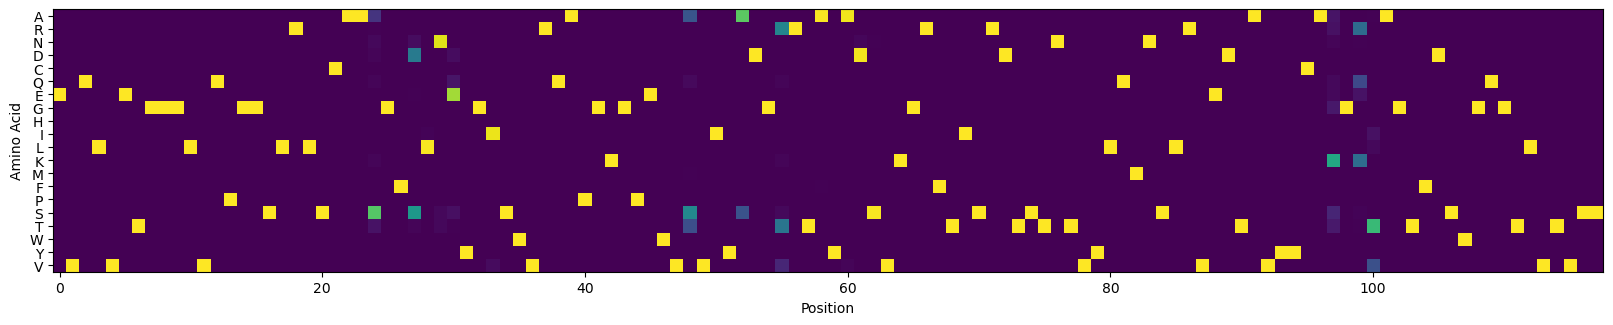

In [69]:
# visualize the CVL
_, ax = plt.subplots(figsize=(20, 4))
ax.imshow(cvl2.T)
_ = ax.set_yticks(np.arange(len(amino_acids)), [c for c in amino_acids])
_ = ax.set_xlabel('Position')
_ = ax.set_ylabel('Amino Acid')
plt.show()

#### Assess the expected performance of the optimized CVL

In [70]:
library_size = 10_000
random = np.random.RandomState(42)
cvl2_sequences_sampled = np.zeros((library_size, cvl2.shape[0]), dtype=int)
for i in range(len(cvl2)):
    cvl2_sequences_sampled[:, i] = random.choice(len(cvl2[i]), p=cvl2[i], size=(library_size), replace=True)
cvl2_sequences_sampled = [''.join([amino_acids[i] for i in cvl2_sequences_sampled[j]]) for j in range(cvl2_sequences_sampled.shape[0])]
# only consider the unique sequences
cvl2_sequences_sampled = np.unique(cvl2_sequences_sampled).tolist()

In [71]:
cvl2_predict_future = model_future.predict(cvl2_sequences_sampled)
print(cvl2_predict_future.job)
cvl2_predict_future.wait_until_done(verbose=True)

job_id='b5fd9cd6-6b3f-44ad-be8c-f03dc51b5938' job_type=<JobType.workflow_predict: '/workflow/predict'> status=<JobStatus.PENDING: 'PENDING'> created_date=None start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=None sequence_length=None result=None


Waiting: 100%|██████████| 100/100 [02:46<00:00,  1.66s/it, status=SUCCESS]


True

In [72]:
cvl2_predict_results = cvl2_predict_future.get()

cvl2_y_mus = np.zeros(len(cvl2_predict_results))
cvl2_y_vars = np.zeros(len(cvl2_predict_results))
for i,r in enumerate(cvl2_predict_results):
    props = r.predictions[0].properties['log_kdnm']
    cvl2_y_mus[i] = props['y_mu']
    cvl2_y_vars[i] = props['y_var']
cvl2_dists = scipy.stats.norm(cvl2_y_mus, np.sqrt(cvl2_y_vars))

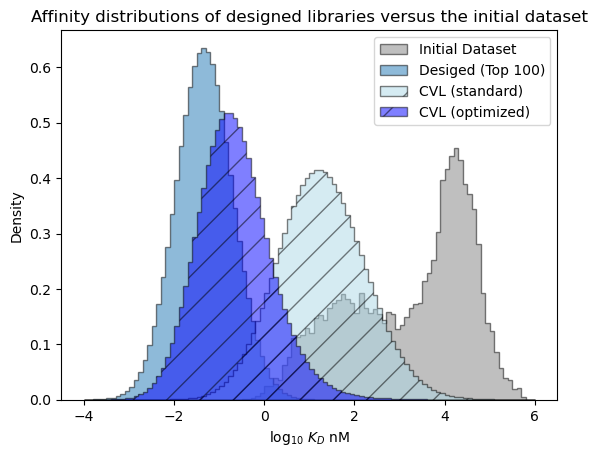

In [73]:
# plot the expected results vs. the input data
bins = np.linspace(-4, 6, 101)

format_params = {'alpha': 0.5, 'histtype': 'stepfilled', 'ec': 'k'}
_ = plt.hist(table['log_kdnm'].values, bins=bins, label='Initial Dataset', color='gray', density=True, **format_params)

# plot the predictive distribution over property values
c_lo = pred_dist_100.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = pred_dist_100.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='Desiged (Top 100)', **format_params)

# compare the expected performance of the 10,000 sequences from the CVL
c_lo = cvl_dists.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = cvl_dists.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='CVL (standard)', color='lightblue', hatch='/', **format_params)

c_lo = cvl2_dists.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = cvl2_dists.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='CVL (optimized)', color='blue', hatch='/', **format_params)

_ = plt.legend(loc='best')
_ = plt.xlabel('log$_{10}$ $K_D$ nM')
_ = plt.ylabel('Density')
_ = plt.title('Affinity distributions of designed libraries versus the initial dataset')

plt.show()

We can see that the CVL derived from variants identified by the design algorithm contains sequences that are expected to perform much better, on average, than the sequences in the standard CVL. Sequences in the optimized CVL are only expected to be slightly worse than the best bespoke variants we identified.

#### Compare the library success statistics

In [ ]:
# what is the probability that a variant meeting the design criteria is present in each library?
# compare the probability of success between the bespoke designs, standard, and optimized CVLs
target = -2
print('target value <', target)

log_one_minus_p_100 = pred_dist_100.logsf(target)
p_100 = 1 - np.exp(np.sum(log_one_minus_p_100))
print(f'Designed, 100 sequences, probability of at least one success = {p_100:.5f}')

log_one_minus_p_cvl = cvl_dists.logsf(target)
p_cvl = 1 - np.exp(np.sum(log_one_minus_p_cvl))
print(f'CVL (standard), 10,000 sequences, probability of at least one success = {p_cvl:.5f}')

log_one_minus_p_cvl2 = cvl2_dists.logsf(target)[:100]
p_cvl2 = 1 - np.exp(np.sum(log_one_minus_p_cvl2))
print(f'CVL (optimized), 100 sequences, probability of at least one success = {p_cvl2:.5f}')

log_one_minus_p_cvl2 = cvl2_dists.logsf(target)[:1000]
p_cvl2 = 1 - np.exp(np.sum(log_one_minus_p_cvl2))
print(f'CVL (optimized), 1,000 sequences, probability of at least one success = {p_cvl2:.5f}')

log_one_minus_p_cvl2 = cvl2_dists.logsf(target)
p_cvl2 = 1 - np.exp(np.sum(log_one_minus_p_cvl2))
print(f'CVL (optimized), 10,000 sequences, probability of at least one success = {p_cvl2:.5f}')

target value < -2
Designed, 100 sequences, probability of at least one success = 1.00000
CVL (standard), 10,000 sequences, probability of at least one success = 0.74083
CVL (optimized), 100 sequences, probability of at least one success = 0.98421
CVL (optimized), 1,000 sequences, probability of at least one success = 1.00000
CVL (optimized), 10,000 sequences, probability of at least one success = 1.00000


In [75]:
# what is the probability that a variant meeting the design criteria is present in each library?
# compare the probability of success between the bespoke designs, standard, and optimized CVLs
target = -3
print('target value <', target)

log_one_minus_p_100 = pred_dist_100.logsf(target)
p_100 = 1 - np.exp(np.sum(log_one_minus_p_100))
print(f'Designed, 100 sequences, probability of at least one success = {p_100:.5f}')

log_one_minus_p_cvl = cvl_dists.logsf(target)
p_cvl = 1 - np.exp(np.sum(log_one_minus_p_cvl))
print(f'CVL (standard), 10,000 sequences, probability of at least one success = {p_cvl:.5f}')

log_one_minus_p_cvl2 = cvl2_dists.logsf(target)[:100]
p_cvl2 = 1 - np.exp(np.sum(log_one_minus_p_cvl2))
print(f'CVL (optimized), 100 sequences, probability of at least one success = {p_cvl2:.5f}')

log_one_minus_p_cvl2 = cvl2_dists.logsf(target)[:1000]
p_cvl2 = 1 - np.exp(np.sum(log_one_minus_p_cvl2))
print(f'CVL (optimized), 1,000 sequences, probability of at least one success = {p_cvl2:.5f}')

log_one_minus_p_cvl2 = cvl2_dists.logsf(target)
p_cvl2 = 1 - np.exp(np.sum(log_one_minus_p_cvl2))
print(f'CVL (optimized), 10,000 sequences, probability of at least one success = {p_cvl2:.5f}')

target value < -3
Designed, 100 sequences, probability of at least one success = 0.33712
CVL (standard), 10,000 sequences, probability of at least one success = 0.00622
CVL (optimized), 100 sequences, probability of at least one success = 0.08272
CVL (optimized), 1,000 sequences, probability of at least one success = 0.48547
CVL (optimized), 10,000 sequences, probability of at least one success = 0.96839


Our predicted probability of finding a success in the optimized CVL is much better than the standard CVL. It isn't as high sequence-for-sequence as the bespoke design, but if we could include more sequences easily in the CVL, then we can reach a higher chance of success.

#### Predicted distribution over the best affinity in each library

Next, let's examine the distribution over the affinity of the *best* sequence we expect to see in each library again but this time including the optimized CVL.

In [76]:
# estimate best affinities in each library from sampling
num_samples = 10_000

r = np.random.randn(num_samples, len(cvl_y_mus))*cvl_dists.std() + cvl_dists.mean()
sample_cvl = r.min(axis=-1)

r = np.random.randn(num_samples, len(cvl2_y_mus))*cvl2_dists.std() + cvl2_dists.mean()
sample_cvl2 = r.min(axis=-1)

r = np.random.randn(num_samples, 100)*pred_dist_100.std() + pred_dist_100.mean()
sample_best_100 = r.min(axis=-1)

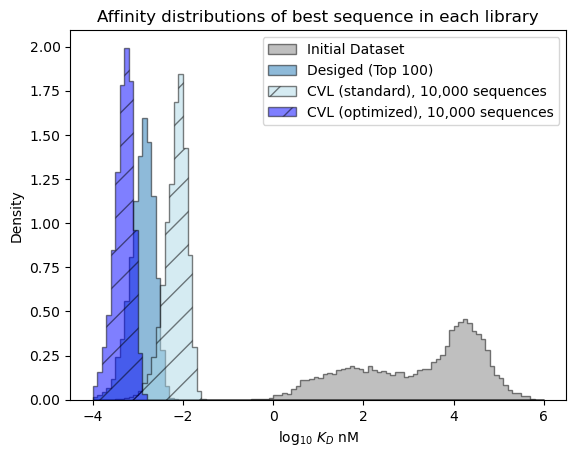

In [77]:
# plot the expected results vs. the input data
bins = np.linspace(-4, 6, 101)

format_params = {'alpha': 0.5, 'histtype': 'stepfilled', 'ec': 'k'}
_ = plt.hist(table['log_kdnm'].values, bins=bins, label='Initial Dataset', color='gray', density=True, **format_params)

# plot the predictive distribution over property values
_ = plt.hist(sample_best_100, bins=bins, label='Desiged (Top 100)', density=True, **format_params)
_ = plt.hist(sample_cvl, bins=bins, label='CVL (standard), 10,000 sequences', color='lightblue', density=True, hatch='/', **format_params)
_ = plt.hist(sample_cvl2, bins=bins, label='CVL (optimized), 10,000 sequences', color='blue', density=True, hatch='/', **format_params)

_ = plt.legend(loc='best')
_ = plt.xlabel('log$_{10}$ $K_D$ nM')
_ = plt.ylabel('Density')
_ = plt.title('Affinity distributions of best sequence in each library')

plt.show()

In [81]:
# plot out the expected best value versus library size
r_des = np.random.randn(num_samples, 1000)*pred_dist_1000.std() + pred_dist_1000.mean()
r_cvl = np.random.randn(num_samples, len(cvl_y_mus))*cvl_dists.std() + cvl_dists.mean()
r_cvl2 = np.random.randn(num_samples, len(cvl2_y_mus))*cvl2_dists.std() + cvl2_dists.mean()
print('Library Size', 'E[Best log KD | Bespoke]', 'E[Best log KD | CVL (standard)]', 'E[Best log KD | CVL (optimized)]', sep='\t')
for i in range(20):
    sample_best = r_des[:, :i+1].min(axis=-1)
    expected_best_value_des = sample_best.mean()
    sample_best = r_cvl[:, :i+1].min(axis=-1)
    expected_best_value_cvl = sample_best.mean()
    sample_best = r_cvl2[:, :i+1].min(axis=-1)
    expected_best_value_cvl2 = sample_best.mean()
    print(f'{i+1: 12d}', f'{expected_best_value_des:24.5f}', f'{expected_best_value_cvl:31.5f}', f'{expected_best_value_cvl2:32.5f}', sep='\t')

Library Size	E[Best log KD | Bespoke]	E[Best log KD | CVL (standard)]	E[Best log KD | CVL (optimized)]
           1	                -1.44800	                        1.53496	                        -0.90248
           2	                -1.78551	                        1.07949	                        -1.31262
           3	                -1.95873	                        0.63560	                        -1.43724
           4	                -2.06677	                        0.29365	                        -1.46655
           5	                -2.14691	                       -0.11400	                        -1.52235
           6	                -2.20587	                       -0.13548	                        -1.60177
           7	                -2.25727	                       -0.17934	                        -1.67963
           8	                -2.30286	                       -0.19725	                        -1.70887
           9	                -2.34049	                       -0.19794	   

 ## Summary and next steps

In this example, we evaluated:
- The initial antibody variable fragment mutagenesis dataset (14H).
- A conventional combinatorial library designed using the top hits from the initial screen.
- A machine learning-designed library using OP Models.
- A combinatorial library based on our machine learning-designed library.

For each library, we were able to predict performance and evaluate the size at which one library performed better than the other. This can be useful for making decisions on library design strategies and size trade-offs between fully bespoke and partially randomized libraries. We also explored a strategy for designing semi-randomized combinatorial variant libraries using the design tool.

We encourage you to try this out on your own libraries when making choices on library size and composition. Happy modeling!
